<a href="https://colab.research.google.com/github/Pablobm3/Detector-de-Balsas/blob/main/SindataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Rutas
directorio_imagenes = "/content/drive/MyDrive/imagenes_balsas/Crop/img/"
directorio_mascaras = "/content/drive/MyDrive/imagenes_balsas/Crop/masks/"
nombres_imagenes = [f"Balsa{i}.tiff" for i in range(1, 14)]
mascaras = [f"Mask{i}.tiff" for i in range(1, 14)]

def dividir_en_subimagenes(imagen, mascara, size=(256, 256), superposicion=50):
    """
    Divide una imagen y su máscara en subimágenes de tamaño dado.

    Args:
        imagen (PIL.Image): Imagen original.
        mascara (PIL.Image): Máscara original.
        size (tuple): Tamaño de los parches (ancho, alto).
        superposicion (int): Cantidad de píxeles de solapamiento entre parches.

    Returns:
        list, list: Lista de subimágenes y lista de submáscaras.
    """
    img_width, img_height = imagen.size
    patch_width, patch_height = size

    subimagenes = []
    submascaras = []

    for i in range(0, img_width, patch_width - superposicion):
        for j in range(0, img_height, patch_height - superposicion):
            # Asegurar que los parches sean del tamaño exacto deseado
            if i + patch_width > img_width:
                i = img_width - patch_width
            if j + patch_height > img_height:
                j = img_height - patch_height

            # Recortar la subimagen y la máscara
            subimg = imagen.crop((i, j, i + patch_width, j + patch_height))
            submask = mascara.crop((i, j, i + patch_width, j + patch_height))

            # Convertirlas a arrays y normalizar
            subimagenes.append(np.array(subimg) / 255.0)
            submascaras.append(np.array(submask) / 255.0)

    return subimagenes, submascaras


def cargar_datos_unet(directorio_imagenes, directorio_mascaras, nombres_imagenes, mascaras, size=(256, 256), superposicion=50):
    """
    Carga imágenes y máscaras, las divide en subimágenes y normaliza los datos.

    Args:
        directorio_imagenes (str): Ruta de las imágenes.
        directorio_mascaras (str): Ruta de las máscaras.
        nombres_imagenes (list): Lista de nombres de imágenes.
        mascaras (list): Lista de nombres de máscaras.
        size (tuple): Tamaño de las subimágenes.
        superposicion (int): Cantidad de píxeles de solapamiento.

    Returns:
        np.array, np.array: Arrays de subimágenes y submáscaras.
    """
    imagenes = []
    etiquetas = []

    for nombre_imagen, nombre_mascara in zip(nombres_imagenes, mascaras):
        # Cargar imágenes y máscaras
        img = Image.open(os.path.join(directorio_imagenes, nombre_imagen))
        mask = Image.open(os.path.join(directorio_mascaras, nombre_mascara))

        # Dividir en subimágenes
        subimgs, submasks = dividir_en_subimagenes(img, mask, size, superposicion)

        imagenes.extend(subimgs)
        etiquetas.extend(submasks)

    # Convertir listas a arrays de NumPy y expandir dimensiones de etiquetas
    return np.array(imagenes), np.expand_dims(np.array(etiquetas), -1)


imagenes_train, etiquetas_train = cargar_datos_unet(directorio_imagenes, directorio_mascaras, nombres_imagenes, mascaras)


# Cargar datos con la nueva función
imagenes, etiquetas = cargar_datos_unet(directorio_imagenes, directorio_mascaras, nombres_imagenes, mascaras, size=(256, 256), superposicion=50)



# Crear un Dataset directamente desde las imágenes y máscaras
train_dataset = tf.data.Dataset.from_tensor_slices((imagenes_train, etiquetas_train))

# Configurar el batch size y prefetch
train_dataset = train_dataset.batch(4).prefetch(buffer_size=tf.data.AUTOTUNE)

# Definir arquitectura U-Net
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size, name='keras_tensor_684')

    # Bloques de codificación
    conv1 = Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bloque de cuello
    conv3 = Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = Conv2D(256, 3, activation="relu", padding="same")(conv3)

    # Bloques de decodificación
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = Concatenate()([up1, conv2])
    conv4 = Conv2D(128, 3, activation="relu", padding="same")(up1)
    conv4 = Conv2D(128, 3, activation="relu", padding="same")(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = Concatenate()([up2, conv1])
    conv5 = Conv2D(64, 3, activation="relu", padding="same")(up2)
    conv5 = Conv2D(64, 3, activation="relu", padding="same")(conv5)

    outputs = Conv2D(1, 1, activation="sigmoid")(conv5)

    return Model(inputs=[inputs], outputs=[outputs])

# Compilar modelo U-Net
modelo_unet = unet()

# Modificar la pérdida
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

modelo_unet.compile(optimizer=Adam(learning_rate=1e-4),
                    loss=lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred),
                    metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)])
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=8, restore_best_weights=True, verbose=1),
    #tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
]

# Entrenar modelo
history = modelo_unet.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=len(imagenes_train) // 4,
    callbacks = callbacks
)

modelo_unet.save('/content/drive/MyDrive/imagenes_balsas/modelos/SindataAugmentation_unet.keras')

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_684']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.9423 - loss: 1.1968 - mean_io_u_3: 0.4988 - learning_rate: 1.0000e-04
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9979 - loss: 0.8554 - mean_io_u_3: 0.4988 - learning_rate: 1.0000e-04
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9982 - loss: 0.4171 - mean_io_u_3: 0.4988 - learning_rate: 1.0000e-04
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.9985 - loss: 0.3845 - mean_io_u_3: 0.4988 - learning_rate: 1.0000e-04
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.9988 - loss: 0.3413 - mean_io_u_3: 0.5010 - learning_rate: 1.0000e-04
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9988 - loss: 0.2986 - mean_io_u_3: 0.5020 - learning_rate: 1.0000e-04
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.9989 - loss: 0.2871 - mean_io_u_3: 0.4999 - learning_rate: 1.0000e-04
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 138

/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:                     loss=lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


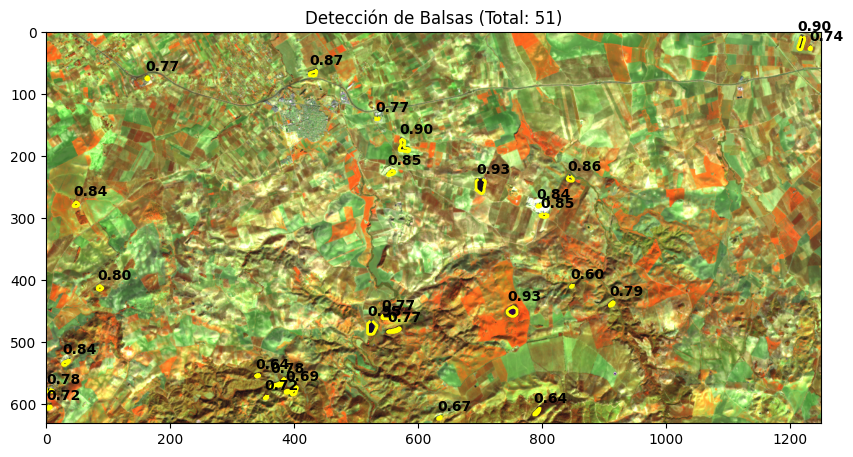

In [16]:
from tensorflow import keras
from scipy.ndimage import label
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf

# Cargar el modelo U-Net
modelo_unet = keras.models.load_model('/content/drive/MyDrive/imagenes_balsas/modelos/CROP_256modelo_unet.keras', safe_mode=False)

# Función para dividir imagen en parches y hacer predicciones
def clasificar_imagen_por_parches(imagen_path, modelo, patch_size=(256, 256), superposicion=50):
    imagen = Image.open(imagen_path)
    ancho, alto = imagen.size
    prediccion_total = np.zeros((alto, ancho))
    contador = np.zeros((alto, ancho))

    for i in range(0, ancho, patch_size[0] - superposicion):
        for j in range(0, alto, patch_size[1] - superposicion):
            i = min(i, ancho - patch_size[0])  # Evitar salir del borde
            j = min(j, alto - patch_size[1])

            subimg = imagen.crop((i, j, i + patch_size[0], j + patch_size[1]))
            subimg_array = np.array(subimg) / 255.0

            prediccion = modelo.predict(np.expand_dims(subimg_array, axis=0),verbose=0)[0, :, :, 0]

            prediccion_total[j:j+patch_size[1], i:i+patch_size[0]] += prediccion
            contador[j:j+patch_size[1], i:i+patch_size[0]] += 1

    prediccion_final = np.divide(prediccion_total, contador, where=contador > 0)
    return prediccion_final

# Clasificar imagen de prueba
imagen_prueba = "/content/drive/MyDrive/imagenes_balsas/tiff_separado/Copia de Balsa36.tiff"
clasificacion = clasificar_imagen_por_parches(imagen_prueba, modelo_unet)
clasificacion_binaria = (clasificacion > 0.1).astype(np.uint8)

# Etiquetado de objetos detectados
estructura = np.ones((3, 3), dtype=int)
marcado, num_balsas = label(clasificacion_binaria, structure=estructura)

# Encontrar contornos en la predicción final
contornos, _ = cv2.findContours(clasificacion_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualización del resultado
imagen_original = Image.open(imagen_prueba)
plt.figure(figsize=(10, 10))
plt.title(f"Detección de Balsas (Total: {num_balsas})")
plt.imshow(imagen_original)

for contorno in contornos:
    mascara = np.zeros_like(clasificacion_binaria, dtype=np.uint8)
    cv2.drawContours(mascara, [contorno], -1, 255, -1)
    probabilidad_promedio = np.mean(clasificacion[mascara == 255])

    # Obtener las dimensiones del contorno
    x, y, w, h = cv2.boundingRect(contorno)
    area = cv2.contourArea(contorno)
    aspect_ratio = max(w / h, h / w)  # Proporción de aspecto

    # Filtrar masas de agua grandes o con forma de río
    if area > 8000 or aspect_ratio > 5:
        continue  # Omitir si es demasiado grande o alargado

    if probabilidad_promedio > 0.6:
        plt.plot(contorno[:, 0, 0], contorno[:, 0, 1], color='yellow', linewidth=2)
        plt.text(x, y - 10, f"{probabilidad_promedio:.2f}", color='black', fontsize=10, fontweight='bold')

plt.show()


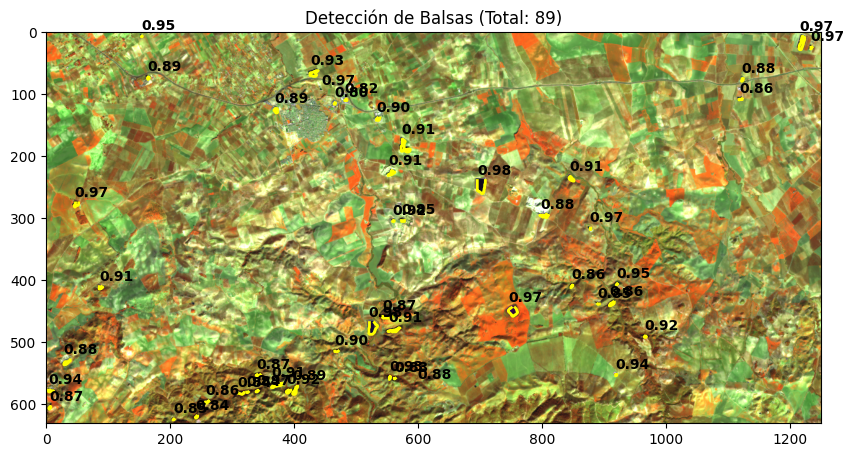

In [17]:
from tensorflow import keras
from scipy.ndimage import label
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf

# Cargar el modelo U-Net
modelo_unet = keras.models.load_model('/content/drive/MyDrive/imagenes_balsas/modelos/SindataAugmentation_unet.keras', safe_mode=False)

# Función para dividir imagen en parches y hacer predicciones
def clasificar_imagen_por_parches(imagen_path, modelo, patch_size=(256, 256), superposicion=50):
    imagen = Image.open(imagen_path)
    ancho, alto = imagen.size
    prediccion_total = np.zeros((alto, ancho))
    contador = np.zeros((alto, ancho))

    for i in range(0, ancho, patch_size[0] - superposicion):
        for j in range(0, alto, patch_size[1] - superposicion):
            i = min(i, ancho - patch_size[0])  # Evitar salir del borde
            j = min(j, alto - patch_size[1])

            subimg = imagen.crop((i, j, i + patch_size[0], j + patch_size[1]))
            subimg_array = np.array(subimg) / 255.0

            prediccion = modelo.predict(np.expand_dims(subimg_array, axis=0),verbose=0)[0, :, :, 0]

            prediccion_total[j:j+patch_size[1], i:i+patch_size[0]] += prediccion
            contador[j:j+patch_size[1], i:i+patch_size[0]] += 1

    prediccion_final = np.divide(prediccion_total, contador, where=contador > 0)
    return prediccion_final

# Clasificar imagen de prueba
imagen_prueba = "/content/drive/MyDrive/imagenes_balsas/tiff_separado/Copia de Balsa36.tiff"
clasificacion = clasificar_imagen_por_parches(imagen_prueba, modelo_unet)
clasificacion_binaria = (clasificacion > 0.1).astype(np.uint8)

# Etiquetado de objetos detectados
estructura = np.ones((3, 3), dtype=int)
marcado, num_balsas = label(clasificacion_binaria, structure=estructura)

# Encontrar contornos en la predicción final
contornos, _ = cv2.findContours(clasificacion_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualización del resultado
imagen_original = Image.open(imagen_prueba)
plt.figure(figsize=(10, 10))
plt.title(f"Detección de Balsas (Total: {num_balsas})")
plt.imshow(imagen_original)

for contorno in contornos:
    mascara = np.zeros_like(clasificacion_binaria, dtype=np.uint8)
    cv2.drawContours(mascara, [contorno], -1, 255, -1)
    probabilidad_promedio = np.mean(clasificacion[mascara == 255])

    # Obtener las dimensiones del contorno
    x, y, w, h = cv2.boundingRect(contorno)
    area = cv2.contourArea(contorno)
    aspect_ratio = max(w / h, h / w)  # Proporción de aspecto

    # Filtrar masas de agua grandes o con forma de río
    if area > 8000 or aspect_ratio > 5:
        continue  # Omitir si es demasiado grande o alargado

    if probabilidad_promedio > 0.8:
        plt.plot(contorno[:, 0, 0], contorno[:, 0, 1], color='yellow', linewidth=2)
        plt.text(x, y - 10, f"{probabilidad_promedio:.2f}", color='black', fontsize=10, fontweight='bold')

plt.show()
